<a href="https://colab.research.google.com/github/cesong2/Display-Sensor/blob/Jinsup/AI4I_2020_Jinsup_230216_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 전체 DATA 전처리 

In [ ]:
# 한글 폰트 설치
! sudo apt-get install -y fonts-nanum
! sudo fc-cache -fv 
! rm ~/.cache/matplotlib -rf

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
plt.rc('font', family='NanumBarunGothic') 

In [2]:
df = pd.read_csv('./ai4i2020.csv')

In [ ]:
df.head(3)

In [ ]:
df.info()

In [ ]:
# 전체 데이터 갯수, 평균 등 파악  
df.describe()

In [3]:
# 변수 컬럼명 변경
# 변수 단위 Air temperature (켈빈온도), Process temperature (켈빈온도), 
# Rotational speed (분당회전수), Torque (회전력/Nm:뉴턴미터) Tool wear (공구 마모 시간/분)
df.rename(columns={'Air temperature [K]':'Air temperature',
                   'Process temperature [K]':'Process temperature',
                   'Rotational speed [rpm]':'Rotational speed',
                   'Torque [Nm]':'Torque',
                   'Tool wear [min]':'Tool wear'},inplace=True)
df.head(3)

,UDI,Product ID,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


In [4]:
# 불필요한 컬럼 (제품번호 등) 제거 
# process temp 은 ait temp 에 10도를 더한 값이나 분석에 필요할 것으로 생각되어 제거하지 않음 
df.drop(['UDI','Product ID'], axis=1, inplace=True)

In [ ]:
df.head(3)

In [5]:
# 온도 단위 변경 / 캘빈 -> 섭씨 / 소수점 1자리
df['Air temperature']=df['Air temperature'].apply(lambda x: x- 273.15).round(1)
df['Process temperature']=df['Process temperature'].apply(lambda x: x- 273.15).round(1)
df.head(3)

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,25.0,35.5,1551,42.8,0,0,0,0,0,0,0
1,L,25.1,35.6,1408,46.3,3,0,0,0,0,0,0
2,L,25.0,35.4,1498,49.4,5,0,0,0,0,0,0


## 2. failure 유,무 DATA 전처리 


In [ ]:
# failure 유무 별 데이터 갯수, 평균 등 파악  
df.groupby('Machine failure').describe()

In [6]:
# 분석에서 제외할 TWF 공구 마모 failure 46개, RNF 랜덤 failure 19개 데이터 파악
df.groupby('Machine failure').sum()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,TWF,HDF,PWF,OSF,RNF
Machine failure,,,,,,,,,,
0,259525.7,356341.9,14880452,382862.1,1030768,0,0,0,0,18
1,9414.7,12603.5,507309,17007.0,48742,46,115,95,98,1


In [7]:
# RNF (random failure) 별도 분석을 위해 failure = 0 데이터만  생성함
df_RNF = df.groupby('Machine failure').get_group(0)
df_RNF.count()

Type                   9661
Air temperature        9661
Process temperature    9661
Rotational speed       9661
Torque                 9661
Tool wear              9661
Machine failure        9661
TWF                    9661
HDF                    9661
PWF                    9661
OSF                    9661
RNF                    9661
dtype: int64

In [8]:
# 마모된 부품(tool wear) 으로 발생한 TWF (tool wear failure) 은 원인이 명확한 바, 삭제를 위해 index 추출   
index_1 = df[df['TWF'] >= 1].index 
index_1

Int64Index([  77, 1087, 1509, 1682, 1763, 1996, 2166, 2244, 2671, 2864, 2941,
            3529, 3611, 3695, 3865, 4034, 4207, 4385, 4469, 4646, 4816, 5141,
            5309, 5401, 5909, 5999, 6172, 6256, 6340, 6419, 6759, 7087, 7426,
            7510, 7687, 7849, 8111, 8199, 8357, 8609, 8690, 8846, 9018, 9174,
            9576, 9758],
           dtype='int64')

In [9]:
# TWF 행 데이터 46개 삭제 
df.drop(index_1, inplace =True)
df.count() 

Type                   9954
Air temperature        9954
Process temperature    9954
Rotational speed       9954
Torque                 9954
Tool wear              9954
Machine failure        9954
TWF                    9954
HDF                    9954
PWF                    9954
OSF                    9954
RNF                    9954
dtype: int64

In [11]:
# failure 발생 원인 알수 없는 RNF (random failures) 로 분류된 행 index 추출
index_2=df[df['RNF']>=1].index
index_2

Int64Index([1221, 1302, 1748, 2072, 2559, 3065, 3452, 5471, 5489, 5495, 5509,
            5553, 5639, 6091, 6913, 6960, 7488, 7868],
           dtype='int64')

In [12]:
# RNF 행 데이터 삭제 
# RNF 데이터 총 19개 이나 TWF 행 데이터 제거시 failue=1 의 RNF 데이터 1개 같이 삭제되어 18개 삭제
df.drop(index_2, inplace=True)
df.count() 

Type                   9936
Air temperature        9936
Process temperature    9936
Rotational speed       9936
Torque                 9936
Tool wear              9936
Machine failure        9936
TWF                    9936
HDF                    9936
PWF                    9936
OSF                    9936
RNF                    9936
dtype: int64

In [13]:
df.groupby('Machine failure').sum()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,TWF,HDF,PWF,OSF,RNF
Machine failure,,,,,,,,,,
0,259027.9,355664.1,14853642,382078.7,1028610,0,0,0,0,0
1,8164.3,10899.0,435265,15266.5,38789,0,115,94,95,0


In [14]:
# TWF, RNF 컬럼 삭제
df.drop(['TWF'], axis= 1, inplace=True)
df.drop(['RNF'], axis= 1, inplace=True)

In [15]:
df.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,HDF,PWF,OSF
count,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000
mean,26.891324,36.892421,1538.738627,39.990459,107.427436,0.029489,0.011574,0.009461,0.009561
std,2.001175,1.483784,179.246092,9.964713,63.358297,0.169180,0.106964,0.096809,0.097318
min,22.200000,32.600000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.200000,35.700000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,37.000000,1503.000000,40.100000,107.000000,0.000000,0.000000,0.000000,0.000000
75%,28.400000,38.000000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000
max,31.400000,40.700000,2886.000000,76.600000,251.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
#failre 별 합계 컬럼 생성
df['failure Total'] = df['HDF'] + df['PWF'] + df['OSF'] 

In [17]:
df.head(3)

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,HDF,PWF,OSF,failure Total
0,M,25.0,35.5,1551,42.8,0,0,0,0,0,0
1,L,25.1,35.6,1408,46.3,3,0,0,0,0,0
2,L,25.0,35.4,1498,49.4,5,0,0,0,0,0


## 2-1 Machine failure 발생 데이터 추출 및 분석 

In [18]:
# Machine failure 발생 데이터 생성
df_failure =df.groupby('Machine failure')

In [19]:
df_failure.groups

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, ...], 1: [50, 69, 160, 161, 168, 194, 207, 242, 248, 249, 259, 327, 380, 442, 463, 586, 603, 746, 847, 880, 903, 926, 1016, 1085, 1095, 1123, 1124, 1144, 1161, 1162, 1167, 1284, 1324, 1334, 1335, 1391, 1419, 1437, 1492, 1496, 1583, 1595, 1784, 1789, 1808, 1833, 2015, 2075, 2125, 2233, 2299, 2331, 2332, 2426, 2444, 2494, 2502, 2581, 2598, 2749, 2761, 2858, 2879, 3000, 3019, 3140, 3236, 3266, 3350, 3356, 3369, 3457, 3528, 3579, 3684, 3760, 3787, 3793, 3806, 3814, 3829, 3854, 3867, 3928, 3935, 3943, 4002, 4024, 4032, 4044, 4048, 4071, 4078, 4080, 4081, 4087, 4096, 4117, 4119, 4120, ...]}

In [99]:
df_failure.describe()

Air temperature                                               \
                          count       mean       std   min   25%   50%   75%   
Machine failure                                                                
0                        9643.0  26.861755  1.991531  22.2  25.2  26.9  28.2   
1                         293.0  27.864505  2.076228  22.5  26.0  28.7  29.5   

                      Process temperature             ...  OSF       \
                  max               count       mean  ...  75%  max   
Machine failure                                       ...             
0                31.4              9643.0  36.883138  ...  0.0  0.0   
1                30.9               293.0  37.197952  ...  1.0  1.0   

                failure Total                                               
                        count      mean       std  min  25%  50%  75%  max  
Machine failure                                                             
0                      9643.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
1                       293.0  1.037543  0.312891  0.0  1.0  1.0  1.0  2.0  

[2 rows x 72 columns]

In [105]:
# 전체 데이터 중 failue 비중 
df_count = df_failure.count()
df_count['count'] =  df_count['Type']
df_count.index= ['Non- failure','Failure']


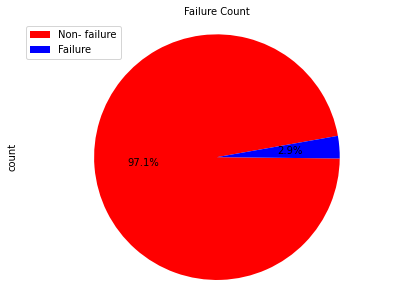

In [107]:
df_count['count'].plot(kind='pie', figsize=(7,5), autopct='%1.1f%%', startangle=10, colors=['red', 'blue' ,'green'], labels=None) 
plt.title('Failure Count', size=10)
plt.axis('equal')
plt.legend(labels=df_count.index, loc = 'upper left')
plt.show()

In [20]:
# failure 없는 그룹 생성
df_fail_0=df_failure.get_group(0)

In [21]:
df_fail_0.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,HDF,PWF,OSF,failure Total
count,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000,9643.0,9643.0,9643.0,9643.0,9643.0
mean,26.861755,36.883138,1540.354869,39.622389,106.669086,0.0,0.0,0.0,0.0,0.0
std,1.991531,1.486919,167.471848,9.468446,62.936149,0.0,0.0,0.0,0.0,0.0
min,22.200000,32.600000,1168.000000,12.600000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,25.200000,35.700000,1429.000000,33.100000,52.000000,0.0,0.0,0.0,0.0,0.0
50%,26.900000,36.900000,1507.000000,39.800000,107.000000,0.0,0.0,0.0,0.0,0.0
75%,28.200000,38.000000,1615.000000,46.300000,160.000000,0.0,0.0,0.0,0.0,0.0
max,31.400000,40.700000,2695.000000,70.000000,246.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
# failue = 0 의 failure Total type 별 비중 
df_fail_0_count = df_fail_0.groupby('Type').count()
df_fail_0_count['count'] =  df_fail_0_count['Torque']
df_fail_0_count.index= ['H-type','L-type','M-type']

In [ ]:
df_fail_0_count['count'].plot(kind='pie', figsize=(7,5), autopct='%1.1f%%', startangle=10, colors=['red', 'blue' ,'green'], labels=None) 
plt.title('Non failure - Type by', size=10)
plt.axis('equal')
plt.legend(labels=df_fail_0_count.index, loc = 'upper left')
plt.show()

In [22]:
# failure 있는 그룹 생성
df_fail_1=df_failure.get_group(1)

In [23]:
 df_fail_1.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,HDF,PWF,OSF,failure Total
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.0,293.000000,293.000000,293.000000,293.000000
mean,27.864505,37.197952,1485.546075,52.104096,132.385666,1.0,0.392491,0.320819,0.324232,1.037543
std,2.076228,1.343552,405.111039,16.320862,71.724965,0.0,0.489141,0.467590,0.468888,0.312891
min,22.500000,33.000000,1181.000000,3.800000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,26.000000,36.600000,1321.000000,48.800000,69.000000,1.0,0.000000,0.000000,0.000000,1.000000
50%,28.700000,37.200000,1359.000000,55.000000,144.000000,1.0,0.000000,0.000000,0.000000,1.000000
75%,29.500000,38.100000,1386.000000,62.000000,201.000000,1.0,1.000000,1.000000,1.000000,1.000000
max,30.900000,40.100000,2886.000000,76.600000,251.000000,1.0,1.000000,1.000000,1.000000,2.000000


## 2-2 failure 발생 유형과 변수간의 상관관계 분석 

In [24]:
# failure Total 과 5가지 변수들의 상관 관계 분석
df_fail_1[['failure Total','Air temperature' , 'Process temperature', 'Rotational speed','Torque', 'Tool wear']].corr( ) 

,failure Total,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
failure Total,1.000000,0.037906,-0.020183,-0.092374,0.238713,0.189492
Air temperature,0.037906,1.000000,0.852737,-0.142160,-0.006598,-0.222754
Process temperature,-0.020183,0.852737,1.000000,-0.083679,0.001859,-0.112615
Rotational speed,-0.092374,-0.142160,-0.083679,1.000000,-0.904965,-0.154020
Torque,0.238713,-0.006598,0.001859,-0.904965,1.000000,0.113984
Tool wear,0.189492,-0.222754,-0.112615,-0.154020,0.113984,1.000000


In [25]:
data_failure_Total = df_fail_1[['failure Total','Air temperature' , 'Process temperature', 'Rotational speed','Torque', 'Tool wear']]

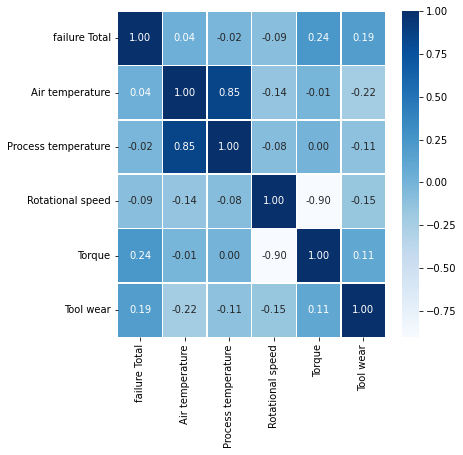

In [27]:
# failure Total 상관 관계 heatmap 
plt.figure(figsize=(6,6))
sns.heatmap(data = data_failure_Total.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

Text(0.5, 1.0, 'Machine failure')

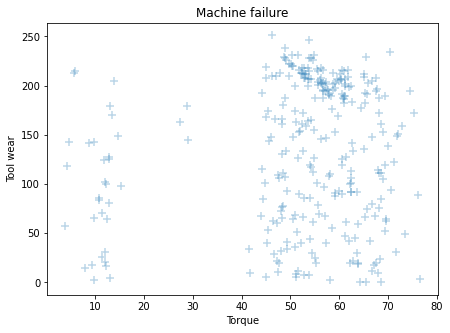

In [28]:
# failure 발생 주요 요인 산점도 분석 (Torque, Tool wear)
df_fail_1.plot(kind='scatter', x='Torque', y='Tool wear', marker = '+', cmap = 'viridis', s=50, alpha=0.3, figsize=(7,5)) 
plt.xlabel('Torque') 
plt.title('Machine failure')

In [29]:
# HDF(heat dissipation) 와 5가지 변수들의 상관 관계 분석 
# -> 공기 온도,  회전력에 영향  
df_fail_1[['HDF','Air temperature' , 'Process temperature', 'Rotational speed','Torque', 'Tool wear']].corr( ) 

,HDF,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
HDF,1.000000,0.611986,0.285232,-0.294717,0.052434,-0.282823
Air temperature,0.611986,1.000000,0.852737,-0.142160,-0.006598,-0.222754
Process temperature,0.285232,0.852737,1.000000,-0.083679,0.001859,-0.112615
Rotational speed,-0.294717,-0.142160,-0.083679,1.000000,-0.904965,-0.154020
Torque,0.052434,-0.006598,0.001859,-0.904965,1.000000,0.113984
Tool wear,-0.282823,-0.222754,-0.112615,-0.154020,0.113984,1.000000


In [30]:
data_HDF = df_fail_1[['HDF','Air temperature' , 'Process temperature', 'Rotational speed','Torque', 'Tool wear']]

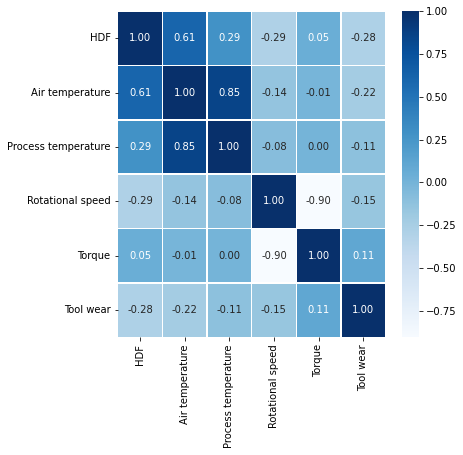

In [31]:
# HDF 상관 관계 heatmap 
plt.figure(figsize=(6,6))
sns.heatmap(data = data_HDF.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

Text(0.5, 0, 'Torque')

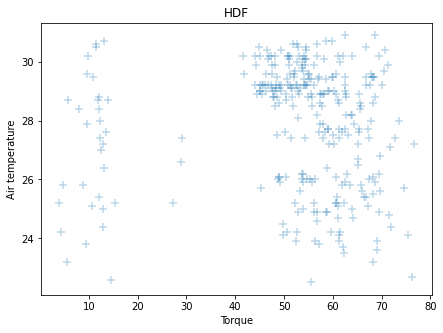

In [32]:
# HDF 주요 요인 산점도 분석 (Torque, Air temperature)
df_fail_1.plot(kind='scatter', x='Torque', y='Air temperature', marker = '+', cmap = 'viridis', s=50, alpha=0.3, figsize=(7,5)) 
plt.title('HDF')
plt.xlabel('Torque')

In [35]:
# PWF(power failure) 와 5가지 변수들의 상관 관계 분석 
# -> 회전수 와 양의 관계 회전력과는 상관없음
df_fail_1[['PWF','Air temperature' , 'Process temperature', 'Rotational speed','Torque', 'Tool wear']].corr( ) 

,PWF,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
PWF,1.000000,-0.301832,-0.183203,0.480393,-0.158942,-0.303608
Air temperature,-0.301832,1.000000,0.852737,-0.142160,-0.006598,-0.222754
Process temperature,-0.183203,0.852737,1.000000,-0.083679,0.001859,-0.112615
Rotational speed,0.480393,-0.142160,-0.083679,1.000000,-0.904965,-0.154020
Torque,-0.158942,-0.006598,0.001859,-0.904965,1.000000,0.113984
Tool wear,-0.303608,-0.222754,-0.112615,-0.154020,0.113984,1.000000


In [36]:
data_PWF = df_fail_1[['PWF','Air temperature' , 'Process temperature', 'Rotational speed','Torque', 'Tool wear']]

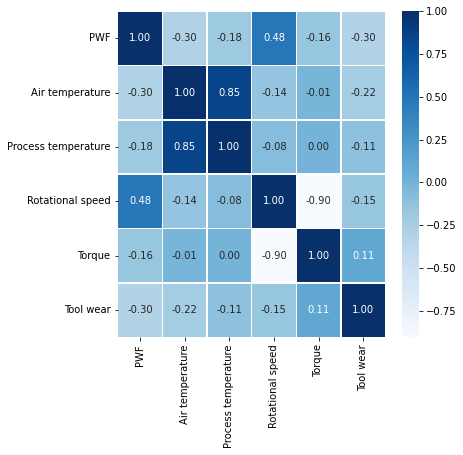

In [37]:
# PWF 상관 관계 heatmap 
plt.figure(figsize=(6,6))
sns.heatmap(data = data_PWF.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

Text(0.5, 0, 'Torque')

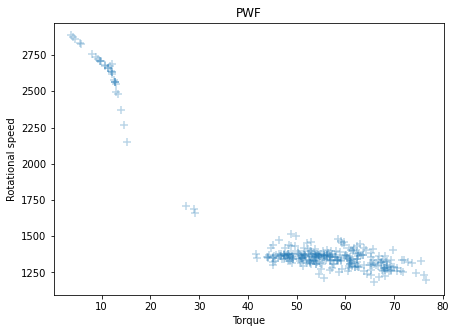

In [38]:
# PWF 주요 요인 산점도 분석 (Rotational speed, Torque)
df_fail_1.plot(kind='scatter', x='Torque', y='Rotational speed', marker = '+', cmap = 'viridis', s=50, alpha=0.3, figsize=(7,5)) 
plt.title('PWF')
plt.xlabel('Torque')

In [39]:
# OSF(overstrain failure) 와 5가지 변수들의 상관 관계 분석 
# -> 회전력과 공구 마모 시간(TWF 0.395 보다 높음) 영향 
df_fail_1[['OSF','Air temperature' , 'Process temperature', 'Rotational speed','Torque', 'Tool wear']].corr( ) 

,OSF,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
OSF,1.000000,-0.312129,-0.128323,-0.233258,0.263097,0.724255
Air temperature,-0.312129,1.000000,0.852737,-0.142160,-0.006598,-0.222754
Process temperature,-0.128323,0.852737,1.000000,-0.083679,0.001859,-0.112615
Rotational speed,-0.233258,-0.142160,-0.083679,1.000000,-0.904965,-0.154020
Torque,0.263097,-0.006598,0.001859,-0.904965,1.000000,0.113984
Tool wear,0.724255,-0.222754,-0.112615,-0.154020,0.113984,1.000000


In [40]:
data_OSF = df_fail_1[['OSF','Air temperature' , 'Process temperature', 'Rotational speed','Torque', 'Tool wear']]

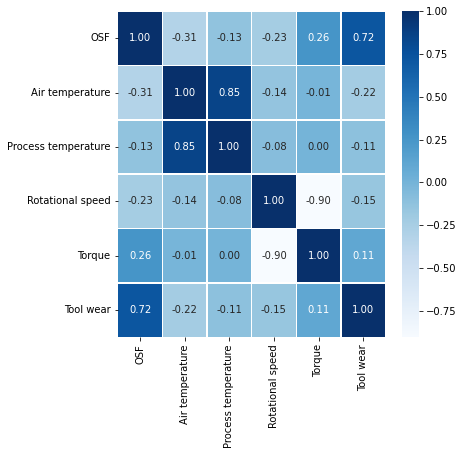

In [41]:
# OSF 상관 관계 heatmap 
plt.figure(figsize=(6,6))
sns.heatmap(data = data_OSF.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

Text(0.5, 0, 'Torque')

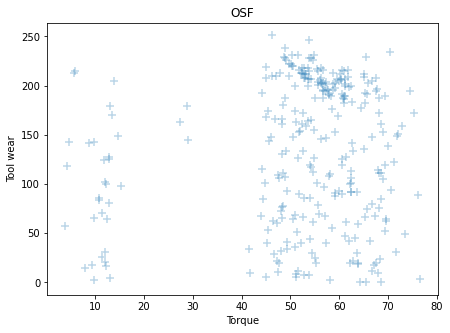

In [42]:
# OSF 주요 요인 산점도 분석 (Tool wear, Torque)
df_fail_1.plot(kind='scatter', x='Torque', y='Tool wear', marker = '+', cmap = 'viridis', s=50, alpha=0.3, figsize=(7,5)) 
plt.title('OSF')
plt.xlabel('Torque')

## 2-4 제외 요인 별도 분석 (RNF)

In [43]:
# failure 미발생 데이터에서 RNF와 5가지 변수들의 상관 관계 분석 
# random failures 전체 18건으로 데이터가 적어 가독성 문제 있음 
# -> 회전수 만 음의 관계 나머지는 양의 관계 있음 
df_RNF[['RNF','Air temperature' , 'Process temperature', 'Rotational speed','Torque', 'Tool wear']].corr( ) 

,RNF,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
RNF,1.000000,0.017191,0.022398,-0.013116,0.017756,0.009057
Air temperature,0.017191,1.000000,0.877797,0.041261,-0.034639,0.014510
Process temperature,0.022398,0.877797,1.000000,0.028751,-0.023683,0.014336
Rotational speed,-0.013116,0.041261,0.028751,1.000000,-0.888688,0.015582
Torque,0.017756,-0.034639,-0.023683,-0.888688,1.000000,-0.024142
Tool wear,0.009057,0.014510,0.014336,0.015582,-0.024142,1.000000


In [44]:
data_RNF = df_RNF[['RNF','Air temperature' , 'Process temperature', 'Rotational speed','Torque', 'Tool wear']]

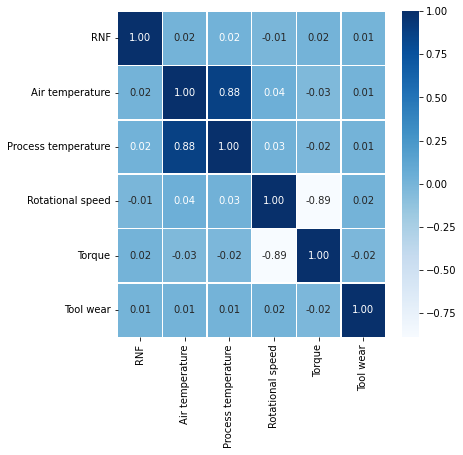

In [45]:
# RNF 상관 관계 heatmap 
plt.figure(figsize=(6,6))
sns.heatmap(data = data_RNF.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

## 3. Type 별 failure 데이터 분석

In [46]:
# type 별 데이터 갯수, 평균 등 파악  
df.groupby('Type').describe()

Air temperature                                                     \
               count       mean       std   min   25%   50%   75%   max   
Type                                                                      
H              992.0  26.752319  2.025223  22.4  25.1  26.7  28.2  31.1   
L             5963.0  26.900872  1.987705  22.2  25.2  27.0  28.4  31.4   
M             2981.0  26.918484  2.018745  22.2  25.2  27.0  28.5  31.2   

     Process temperature             ...  OSF      failure Total            \
                   count       mean  ...  75%  max         count      mean   
Type                                 ...                                     
H                  992.0  36.814718  ...  0.0  1.0         992.0  0.013105   
L                 5963.0  36.898206  ...  0.0  1.0        5963.0  0.037230   
M                 2981.0  36.906709  ...  0.0  1.0        2981.0  0.023147   

                                         
           std  min  25%  50%  75%  max  
Type                                     
H     0.113781  0.0  0.0  0.0  0.0  1.0  
L     0.203019  0.0  0.0  0.0  0.0  2.0  
M     0.159069  0.0  0.0  0.0  0.0  2.0  

[3 rows x 80 columns]

In [47]:
# Type 별 failure 발생 여부 별 갯수 비교
df_table1 = pd.pivot_table(df, index=['Machine failure','failure Total'],columns='Type',values='Torque', aggfunc='count', fill_value=0, margins = True)
df_table1  

Type                             H     L     M   All
Machine failure failure Total                       
0               0              978  5753  2912  9643
1               0                1     4     4     9
                1               13   190    61   264
                2                0    16     4    20
All                            992  5963  2981  9936

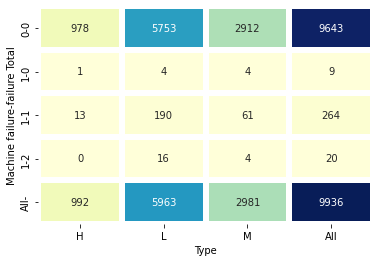

In [48]:
# heat map (Type 별 failure 발생 여부 별 갯수)
sns.heatmap(df_table1, annot=True, fmt='d', cmap='YlGnBu', linewidth=5, cbar = False)  
plt.show()

In [86]:
# failue = 0 의 failure Total type 별 비중 
df_fail_0_count = df_fail_0.groupby('Type').count()
df_fail_0_count['count'] =  df_fail_0_count['Torque']
df_fail_0_count.index= ['H-type','L-type','M-type']

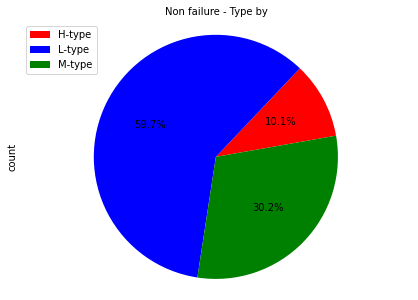

In [92]:
df_fail_0_count['count'].plot(kind='pie', figsize=(7,5), autopct='%1.1f%%', startangle=10, colors=['red', 'blue' ,'green'], labels=None) 
plt.title('Non failure - Type by', size=10)
plt.axis('equal')
plt.legend(labels=df_fail_0_count.index, loc = 'upper left')
plt.show()

In [93]:
# failue = 1 의 failure Total type 별 비중
df_fail_1_count = df_fail_1.groupby('Type').count()
df_fail_1_count['count'] =  df_fail_1_count['Torque']
df_fail_1_count.index= ['H-type','L-type','M-type']

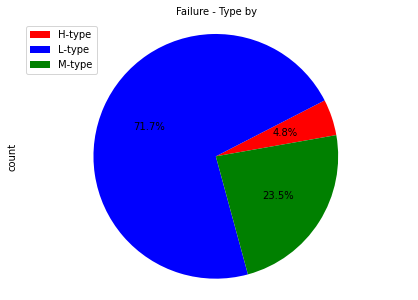

In [94]:
df_fail_1_count['count'].plot(kind='pie', figsize=(7,5), autopct='%1.1f%%', startangle=10, colors=['red', 'blue' ,'green'], labels=None) 
plt.title('Failure - Type by', size=10)
plt.axis('equal')
plt.legend(labels=df_fail_1_count.index, loc = 'upper left')
plt.show()